# THIS FILE IS IN THE HANDOUTS FOLDER. COPY IT INTO YOUR CLASS NOTES

- [**Read the chapter on the website!**](https://ledatascifi.github.io/ledatascifi-2024/content/05/02_reg.html) It contains a lot of extra information we won't cover in class extensively.
- After reading that, I recommend [this webpage as a complimentary place to get additional intuition.](https://aeturrell.github.io/coding-for-economists/econmt-regression.html)

## Today

[Finish picking teams and declare initial project interests in the project sheet](https://docs.google.com/spreadsheets/d/1SMetWKgI3JdhFdBwihDgIY3BDubvihkJCWbgLcCe4fs/edit?usp=sharing)


# Today is mostly about INTERPRETING COEFFICIENTS (6.4 in the book)

1. 25 min reading groups: Talk/read through two regression pages (6.3 and 6.4) 
    - Assemble your own notes. Perhaps in the "Module 4 notes" file, but you can do this in any file you want.
    - After class, each group will email their notes to the TA/me for participation. (Effort grading.)
1. 10 min: class builds joint "big takeaways and nuanced observations" 
1. 5 min: Interpret models 1-2 as class as practice. 
1. 20 min reading groups: Work through remaining problems below.
1. 10 min: wrap up  

---

In [1]:
import pandas as pd
from statsmodels.formula.api import ols as sm_ols
import numpy as np
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col # nicer tables


In [2]:
url = 'https://github.com/LeDataSciFi/ledatascifi-2024/blob/main/data/Fannie_Mae_Plus_Data.gzip?raw=true'
fannie_mae = pd.read_csv(url,compression='gzip') 

## Clean the data and create variables you want

In [3]:
fannie_mae = (fannie_mae
                  # create variables
                  .assign(l_credscore = np.log(fannie_mae['Borrower_Credit_Score_at_Origination']),
                          l_LTV = np.log(fannie_mae['Original_LTV_(OLTV)']),
                          l_int = np.log(fannie_mae['Original_Interest_Rate']),
                          Origination_Date = lambda x: pd.to_datetime(x['Origination_Date']),
                          Origination_Year = lambda x: x['Origination_Date'].dt.year,
                          const = 1
                         )
                  .rename(columns={'Original_Interest_Rate':'int'}) # shorter name will help the table formatting
             )

# create a categorical credit bin var with "pd.cut()"
fannie_mae['creditbins']= pd.cut(fannie_mae['Co-borrower_credit_score_at_origination'],
                                 [0,579,669,739,799,850],
                                 labels=['Very Poor','Fair','Good','Very Good','Exceptional'])


In [7]:
fannie_mae['Original_LTV_(OLTV)'].mode() 

0    80.0
Name: Original_LTV_(OLTV), dtype: float64

## Statsmodels

As before, the psuedocode:
```python
model = sm_ols(<formula>, data=<dataframe>)
result=model.fit()

# you use result to print summary, get predicted values (.predict) or residuals (.resid)
```

Now, let's save each regression's result with a different name, and below this, output them all in one nice table:

In [4]:
# one var: 'y ~ x' means fit y = a + b*X

reg1 = sm_ols('int ~  Borrower_Credit_Score_at_Origination ', data=fannie_mae).fit()

reg1b= sm_ols('int ~  l_credscore  ',  data=fannie_mae).fit()

reg1c= sm_ols('l_int ~  Borrower_Credit_Score_at_Origination  ',  data=fannie_mae).fit()

reg1d= sm_ols('l_int ~  l_credscore  ',  data=fannie_mae).fit()

# multiple variables: just add them to the formula
# 'y ~ x1 + x2' means fit y = a + b*x1 + c*x2
reg2 = sm_ols('int ~  l_credscore + l_LTV ',  data=fannie_mae).fit()

# interaction terms: Just use *
# Note: always include each variable separately too! (not just x1*x2, but x1+x2+x1*x2)
reg3 = sm_ols('int ~  l_credscore + l_LTV + l_credscore*l_LTV',  data=fannie_mae).fit()
      
# categorical dummies: C() 
reg4 = sm_ols('int ~  C(creditbins)  ',  data=fannie_mae).fit()

reg5 = sm_ols('int ~  C(creditbins)  -1', data=fannie_mae).fit()


In [5]:
reg1c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  l_int   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                 1.941e+04
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:06:26   Log-Likelihood:                 3177.4
No. Observations:              134481   AIC:                            -6351.
Df Residuals:                  134479   BIC:                            -6331.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                2.8713      0.009    319.817      0.000       2.854       2.889
Borrower_Credit_Score_at_Origination    -0.0017   1.21e-05   -139.317      0.000      -0.002      -0.002
==============================================================================
Omnibus:                     1969.599   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1514.883
Skew:                          -0.175   Prob(JB):                         0.00
Kurtosis:                       2.615   Cond. No.                     1.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ok, time to output them:

In [5]:
# now I'll format an output table
# I'd like to include extra info in the table (not just coefficients)
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'Adj R-squared' : lambda x: f"{x.rsquared_adj:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

# q4b1 and q4b2 name the dummies differently in the table, so this is a silly fix
reg4.model.exog_names[1:] = reg5.model.exog_names[1:]  

# This summary col function combines a bunch of regressions into one nice table
print('='*108)
print('                  y = interest rate if not specified, log(interest rate else)')
print(summary_col(results=[reg1,reg1b,reg1c,reg1d,reg2,reg3,reg4,reg5], # list the result obj here
                  float_format='%0.2f',
                  stars = True, # stars are easy way to see if anything is statistically significant
                  model_names=['1','2',' 3 (log)','4 (log)','5','6','7','8'], # these are bad names, lol. Usually, just use the y variable name
                  info_dict=info_dict,
                  regressor_order=[ 'Intercept','Borrower_Credit_Score_at_Origination','l_credscore','l_LTV','l_credscore:l_LTV',
                                  'C(creditbins)[Very Poor]','C(creditbins)[Fair]','C(creditbins)[Good]','C(creditbins)[Vrey Good]','C(creditbins)[Exceptional]']
                  )
     )

                  y = interest rate if not specified, log(interest rate else)

                                        1        2      3 (log) 4 (log)     5         6        7        8   
------------------------------------------------------------------------------------------------------------
Intercept                            11.58*** 45.37*** 2.87***  9.50***  44.13*** -16.81*** 6.65***         
                                     (0.05)   (0.29)   (0.01)   (0.06)   (0.30)   (4.11)    (0.08)          
Borrower_Credit_Score_at_Origination -0.01***          -0.00***                                             
                                     (0.00)            (0.00)                                               
l_credscore                                   -6.07***          -1.19*** -5.99*** 3.22***                   
                                              (0.04)            (0.01)   (0.04)   (0.62)                    
l_LTV                                            

# Today. Work in groups. Refer to the lectures. 

You might need to print out a few individual regressions with more decimals.

1. Interpret coefs in model 1-4
1. Interpret coefs in model 5
1. Interpret coefs in model 6 (and visually?)
1. Interpret coefs in model 7 (and visually? + comp to table)
1. Interpret coefs in model 8 (and visually? + comp to table)
1. Add l_LTV  to Model 8 and interpret (and visually?)





Model 1
- Intercept: A borrower with a credit score of 0 has an int rate of 11.58 on average in the data
- Beta: A one unit increase in credit score, is associated with a 0.01 p.p. decline in int rate (1 b.p., 0.01 p.p.)
- If score = 700, 4.58% int
- If 701 --> 4.57  (X up one unit)
- If 707 --> 4.51  (X up one %)  (down 7b.p.)

In [6]:
11.58-0.01 * 700

4.58

In [7]:
11.58-0.01 * 701

4.57

Model 2: 
- Intercept: A borrower with a credit score of 0 has an int rate of 45.37 on average in the data
- Beta: A one percent increase in credit score, is associated with a 0.0607 p.p. decline in int rate 
- If score = 700, 5.67% int
- If 707 --> 5.61 (X up one %) (x down 6b.p.)


In [9]:
import numpy as np
45.37 - 6.06*np.log(700)
45.37 - 6.06*np.log(707)

5.610154164666767

Model 3:

- Intercept: A borrower with a credit score of 0 has an int rate of 17.63 on average in the data
- Beta: A one unit increase in credit score, is associated with a 0.17% decline in int rate
- If score = 700, 5.37% int
- If 707 --> 5.30 (X up seven unit) (x down 6b.p.)

In [18]:
np.exp(2.87)
np.exp(2.87-0.0017*700)
5.37*(1-0.0017)**7   # proportional change, 7 times 
np.exp(2.87-0.0017*707)


5.302084260759588

Model 4:

- Intercept: A borrower with a credit score of 1 has an int rate of HIGH (meaningless) on average in the data
- Beta: A one percent increase in credit score, is associated with a 1.19% decline in int rate
- If score = 700, 5.49% int
- If 707 --> 5.43 (X up seven unit) (x down 6b.p.)

In [23]:
np.exp(9.5)
np.exp(9.5 - 1.19*np.log(700))
np.exp(9.5 - 1.19*np.log(707))


5.432359161191803

Model 5 - dhrunal, jimmy + danny 

- Beta: A one percent increase in credit score, is associated with a 0.0599 p.p. (5.99 b.p.) decline in int rate, **holding all other variables (logLTV) constant**
- If score = 700, 4.72% int
- If 707 --> 4.66 (X up one %) (x down 6b.p.)



In [ ]:
# using the mean LTV in the data (.7)

In [9]:
44 - 5.99*np.log(700) + .15*np.log(.8)

4.725557260392872

In [8]:
44 - 5.99*np.log(707) + .15*np.log(.8)

4.6659547785823925

- log(LTV): A one percent increase in LTV (say: 50% to 50.5%), is associated with a 0.0015 p.p. decline in int rate, **holding log(credit score) constant*

Model 6 - ryan and ziggy - impact of changes of credit score

Model 6: 
- credit score: A one percent increase in credit score, is associated with
   - a 0.032 p.p. decline in int rate if log(LTV) = 0
   - a _____ p.p. decline in int rate if log(LTV) = #
- interaction term: 
- If score = 700, 5.67% int
- If 707 --> 5.61 (X up one %) (x down 6b.p.)

In [10]:
-16 +3.2*np.log(700) + 14.6 *np.log(.8) - 2.2*np.log(700) *np.log(.8) 

4.921590150945223

In [11]:
-16 +3.2*np.log(707) + 14.6 *np.log(.8) - 2.2*np.log(707) *np.log(.8) 

4.958315984434684

Model 7 - front right 

Board work!

Model 8 - catty corner rivalry 

Board work!

In [14]:
sm_ols('int ~  C(creditbins)  -1 + Borrower_Credit_Score_at_Origination', data=fannie_mae).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    int   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     2370.
Date:                Wed, 27 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:07:56   Log-Likelihood:            -1.0719e+05
No. Observations:               67157   AIC:                         2.144e+05
Df Residuals:                   67151   BIC:                         2.145e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(creditbins)[Very Poor]                10.8346      0.111     97.204      0.000      10.616      11.053
C(creditbins)[Fair]                     10.6141      0.087    121.393      0.000      10.443      10.786
C(creditbins)[Good]                     10.4258      0.093    112.210      0.000      10.244      10.608
C(creditbins)[Very Good]                10.2787      0.099    103.984      0.000      10.085      10.472
C(creditbins)[Exceptional]               9.8752      0.103     95.922      0.000       9.673      10.077
Borrower_Credit_Score_at_Origination    -0.0069      0.000    -53.522      0.000      -0.007      -0.007
==============================================================================
Omnibus:                     1473.645   Durbin-Watson:                   0.436
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1529.539
Skew:                           0.356   Prob(JB):                         0.00
Kurtosis:                       2.802   Cond. No.                     3.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
10.8-579*0.0069

6.804900000000001

In [16]:
10.6-580*0.0069

6.598

## Plot m1-m4

In [16]:
reg1.predict(fannie_mae['Borrower_Credit_Score_at_Origination'])

0         5.860809
1         5.655570
2         5.245091
3         4.706338
4         5.954878
            ...   
135033    5.450331
135034    5.792396
135035    4.843164
135036    6.271288
135037    5.937774
Length: 135038, dtype: float64

In [17]:
subset = fannie_mae.dropna(subset=['Borrower_Credit_Score_at_Origination','l_credscore']).copy()

subset['r1'] = reg1.predict(fannie_mae['Borrower_Credit_Score_at_Origination'])
subset['r2'] = reg1b.predict(fannie_mae['l_credscore'])
subset['r3'] = reg1c.predict(fannie_mae['Borrower_Credit_Score_at_Origination'])
subset['r4'] = reg1d.predict(fannie_mae['l_credscore'])

<Axes: xlabel='Borrower_Credit_Score_at_Origination'>

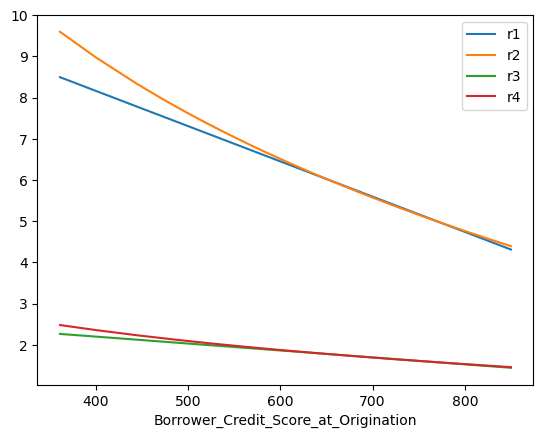

In [18]:
subset[['r1','r2','r3','r4','Borrower_Credit_Score_at_Origination']].sort_values('Borrower_Credit_Score_at_Origination').set_index('Borrower_Credit_Score_at_Origination').plot()

